In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [2]:
# Dataset path
dataset_path = "C:\\Users\\ASUS\\Brain Tumor Classification"

# Function for image load
def load_images(folder_path, image_size=(64,64)):
    data = []
    labels = []

    label = os.path.basename(folder_path)  # Extract the label from the folder name

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)  # Resize images to a common size
        data.append(img)
        labels.append(label)

    return np.array(data), np.array(labels)

# Function for rotating images (Augmentation)
def rotate_images(images, labels, target_count=3500):
    rotated_images = []
    rotated_labels = []

    current_count = len(images)
    rotation_angle = 10  # Angle of rotation in degrees

    while current_count < target_count:
        for i in range(len(images)):
            # Rotate the image
            rotated_img = cv2.rotate(images[i], cv2.ROTATE_90_CLOCKWISE)
            rotated_images.append(rotated_img)
            rotated_labels.append(labels[i])

            # Rotate the image again for more augmentation
            rotated_img = cv2.rotate(images[i], cv2.ROTATE_180)
            rotated_images.append(rotated_img)
            rotated_labels.append(labels[i])

            # Rotate the image one more time for additional augmentation
            rotated_img = cv2.rotate(images[i], cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_images.append(rotated_img)
            rotated_labels.append(labels[i])

            current_count += 3  # Count three rotations
            if current_count >= target_count:
                break

    return np.array(rotated_images), np.array(rotated_labels)

# Load images for each type of brain tumor
data_glioma, labels_glioma = load_images(os.path.join(dataset_path, 'glioma_tumor'))
data_meningioma, labels_meningioma = load_images(os.path.join(dataset_path, 'meningioma_tumor'))
data_pituitary, labels_pituitary = load_images(os.path.join(dataset_path, 'pituitary_tumor'))

# Augment images
augmented_data_glioma, augmented_labels_glioma = rotate_images(data_glioma, labels_glioma, target_count=3500)
augmented_data_meningioma, augmented_labels_meningioma = rotate_images(data_meningioma, labels_meningioma, target_count=3500)
augmented_data_pituitary, augmented_labels_pituitary = rotate_images(data_pituitary, labels_pituitary, target_count=3500)

# Concatenate augmented data with original data
data_glioma = np.concatenate((data_glioma, augmented_data_glioma), axis=0)
labels_glioma = np.concatenate((labels_glioma, augmented_labels_glioma), axis=0)
data_meningioma = np.concatenate((data_meningioma, augmented_data_meningioma), axis=0)
labels_meningioma = np.concatenate((labels_meningioma, augmented_labels_meningioma), axis=0)
data_pituitary = np.concatenate((data_pituitary, augmented_data_pituitary), axis=0)
labels_pituitary = np.concatenate((labels_pituitary, augmented_labels_pituitary), axis=0)

In [3]:
# Combine data and labels for all tumor types
All_data = np.concatenate([data_glioma, data_pituitary, data_meningioma])
All_labels = np.concatenate([labels_glioma, labels_meningioma, labels_pituitary])

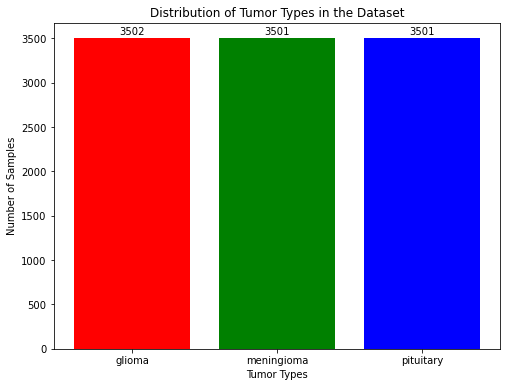

In [4]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green', 'blue'])
plt.xlabel('Tumor Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Tumor Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['glioma', 'meningioma', 'pituitary'])
plt.show()

In [5]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0

In [6]:
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.15, random_state=42
)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [8]:
image_size = (64, 64)
num_classes = 3

In [9]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

# CNN layers with Dropout
x = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)  # Adding Dropout after the first max pooling layer
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)  # Adding Dropout after the second max pooling layer
x = Flatten()(x)

# Reshape the output to fit the LSTM input
x = Reshape((1, -1))(x)

# Single LSTM layer with Dropout
lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.25)(lstm_out)  # Adding Dropout after LSTM layer

# Attention mechanism
attention_output = Attention()(lstm_out)

# Skip connection to final dense layer
combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

# Final dense layer
outputs = Dense(num_classes, activation="softmax")(combined_output)

# Define the combined model
combined_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
combined_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Callbacks
checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

# Model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 16)           448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 31, 31, 16)           0         ['max_pooling2d[0][0]']   

In [10]:
# Train the model with callbacks
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=20,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
475/475 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.7143

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


475/475 [==============================] - 58s 86ms/step - loss: 0.6435 - accuracy: 0.7143 - val_loss: 0.7953 - val_accuracy: 0.6582
Epoch 2/20
475/475 [==============================] - 40s 84ms/step - loss: 0.5012 - accuracy: 0.7837 - val_loss: 0.7295 - val_accuracy: 0.6604
Epoch 3/20
475/475 [==============================] - 41s 87ms/step - loss: 0.4186 - accuracy: 0.8218 - val_loss: 0.6122 - val_accuracy: 0.7313
Epoch 4/20
475/475 [==============================] - 43s 90ms/step - loss: 0.3563 - accuracy: 0.8546 - val_loss: 0.5283 - val_accuracy: 0.7716
Epoch 5/20
475/475 [==============================] - 43s 90ms/step - loss: 0.3057 - accuracy: 0.8772 - val_loss: 0.3496 - val_accuracy: 0.8530
Epoch 6/20
475/475 [==============================] - 41s 86ms/step - loss: 0.2570 - accuracy: 0.8972 - val_loss: 0.3027 - val_accuracy: 0.8694
Epoch 7/20
475/475 [==============================] - 43s 90ms/step - loss: 0.2304 - accuracy: 0.9109 - val_loss: 0.2503 - val_accuracy: 0.8993
Epo

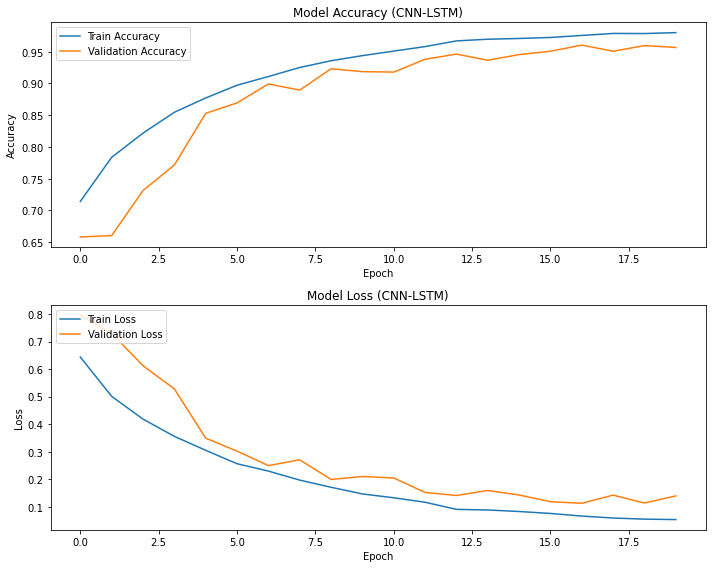

In [11]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy (CNN-LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss (CNN-LSTM)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [12]:
# Evaluate the model on the test set
test_predictions1 = combined_model.predict(test_data)
test_predictions_classes1 = np.argmax(test_predictions1, axis=1)
CNN_LSTM_class_report1 = classification_report(test_labels, test_predictions_classes1, target_names=label_encoder.classes_)
print("Classification Report:\n", CNN_LSTM_class_report1)

50/50 [==============================] - 1s 13ms/step
Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.97      0.96      0.96       546
meningioma_tumor       0.98      0.98      0.98       516
 pituitary_tumor       0.95      0.96      0.96       514

        accuracy                           0.97      1576
       macro avg       0.97      0.97      0.97      1576
    weighted avg       0.97      0.97      0.97      1576



In [13]:
accuracy = accuracy_score(test_labels, test_predictions_classes1)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 96.76%


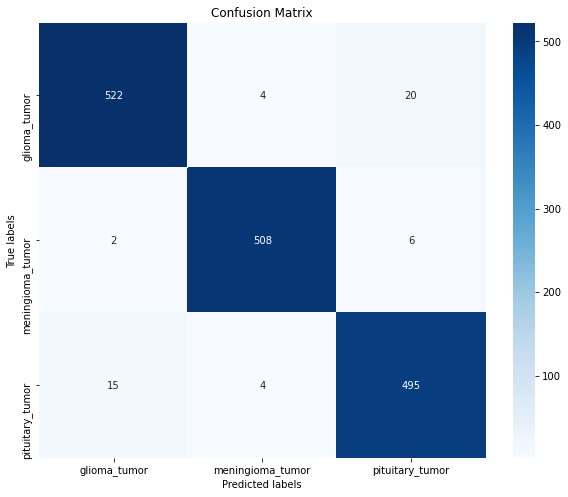

In [14]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
#combined_model.save("trained_combined_model.h5")

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


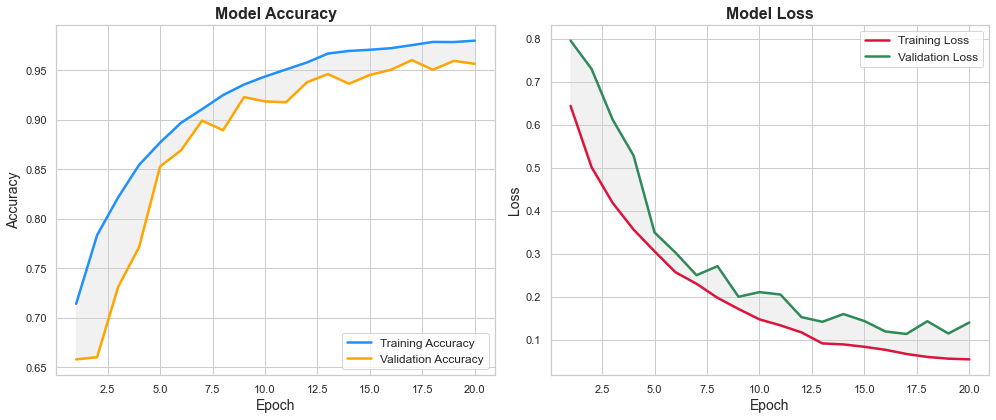

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a beautiful style for the plots
sns.set(style="whitegrid")

# Manually inputting the values based on the provided history
epochs = list(range(1, 21))
train_loss = [0.6435, 0.5012, 0.4186, 0.3563, 0.3057, 0.2570, 0.2304, 0.1977, 0.1718, 0.1476, 0.1337, 0.1174, 0.0917, 0.0894, 0.0839, 0.0769, 0.0673, 0.0603, 0.0563, 0.0547]
train_accuracy = [0.7143, 0.7837, 0.8218, 0.8546, 0.8772, 0.8972, 0.9109, 0.9251, 0.9358, 0.9439, 0.9510, 0.9581, 0.9671, 0.9697, 0.9709, 0.9725, 0.9756, 0.9788, 0.9787, 0.9801]
val_loss = [0.7953, 0.7295, 0.6122, 0.5283, 0.3496, 0.3027, 0.2503, 0.2713, 0.2002, 0.2109, 0.2054, 0.1529, 0.1420, 0.1600, 0.1437, 0.1195, 0.1137, 0.1433, 0.1148, 0.1404]
val_accuracy = [0.6582, 0.6604, 0.7313, 0.7716, 0.8530, 0.8694, 0.8993, 0.8896, 0.9231, 0.9187, 0.9179, 0.9381, 0.9463, 0.9366, 0.9455, 0.9507, 0.9604, 0.9507, 0.9597, 0.9567]

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='dodgerblue', linewidth=2.5)
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange', linewidth=2.5)
plt.fill_between(epochs, train_accuracy, val_accuracy, color='lightgray', alpha=0.3)
plt.title('Model Accuracy', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='crimson', linewidth=2.5)
plt.plot(epochs, val_loss, label='Validation Loss', color='seagreen', linewidth=2.5)
plt.fill_between(epochs, train_loss, val_loss, color='lightgray', alpha=0.3)
plt.title('Model Loss', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()